# Data Augmenter Tutorial 
 
This tutorial demonstrates how to use the data augmenter class with the data generated by Dennis.


##### Get the new sorted dataset [here](https://tumde-my.sharepoint.com/:f:/g/personal/gohdennis_tum_de/EmooVZ4vE95Iic-HIP9-P10BzX7oIOBmRhK8Q9tYzfJWRQ?e=maOqo5) [08_Aug_2022]

Annotations are stored under notebooks/preprocesing/restructured_w_original_labels.json (also in the .zip file)

Extract the zip under data/.
 #### [1. Imports](#title_1)
 #### [2. Applying Data Augmentation](#title_2)


<hr style="height:2px;border-width:0;color:black;background-color:black">

<a id="title_1"></a>
## 1. Imports
<br />

Required imports and loading image data.

In [1]:
import sys
from preprocessing.data_augmenter import DataAugmenter
import json
import os
from PIL import Image
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2022-08-25 10:46:34.091125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 10:46:34.091166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# get current working directory

with Path(os.getenv('DATA'),'restructured_w_original_labels.json').open() as f:
    data = json.load(f)

In [3]:
# get informations
categories = data['categories']
images = data['images']
annotations = data['annotations']

print(f"#categories: {len(categories)}")
print(f"#images: {len(images)}")
print(f"#annotations: {len(annotations)}")
print(f'Classes: {[x["name"] for x in categories]}')

#categories: 4
#images: 9585
#annotations: 897
Classes: ['dent', 'other', 'rim', 'scratch']


<a id="title_2"></a>
## 2. Applying Data Augmentation
<br />

#### 2.1 Load data from disk

The data is then split into a training and validation set.

In [4]:
image_path = Path(os.getenv('DATA'), 'sort')

train_ds = tf.keras.utils.image_dataset_from_directory(directory=image_path, validation_split=0.3, subset='training', seed=0, image_size=(224, 224))
val_ds = tf.keras.utils.image_dataset_from_directory(directory=image_path, validation_split=0.3, subset='validation', seed=0, image_size=(224, 224))

Found 897 files belonging to 4 classes.
Using 628 files for training.
Found 897 files belonging to 4 classes.
Using 269 files for validation.


2022-08-25 10:46:38.537470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 10:46:38.537509: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 10:46:38.537522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dens): /proc/driver/nvidia/version does not exist
2022-08-25 10:46:38.537781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 2.2 Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#### 2.3 Prepare variables that decide augmentation method
When selecting the desired augmentation method the "method" dictionary is changed. An example is given below. "target_size" defines how big the new augmented data set should be. 

In [6]:
method = {'brightness': {'max_delta': 0.5}, 'contrast': {'upper': 0.9, 'lower': 0.1}, 'saturation': {'upper': 0.9, 'lower': 0.1}, 'hue': {'max_delta': 0.5}, 'flip_lr': {'placeholder': 0}}
print(method.keys())


dict_keys(['brightness', 'contrast', 'saturation', 'hue', 'flip_lr'])


#### 2.4 Generate augmented data set
The class is called and the "transform" function is used. 

In [7]:
Augmenter = DataAugmenter()

seed= (np.random.randint(0, 100), np.random.randint(0, 100))
aug_ds = Augmenter.transform(train_ds, seed, **method)


#### 2.5 Comparison 
Comapre the plots of augmented and unaugmented dataset

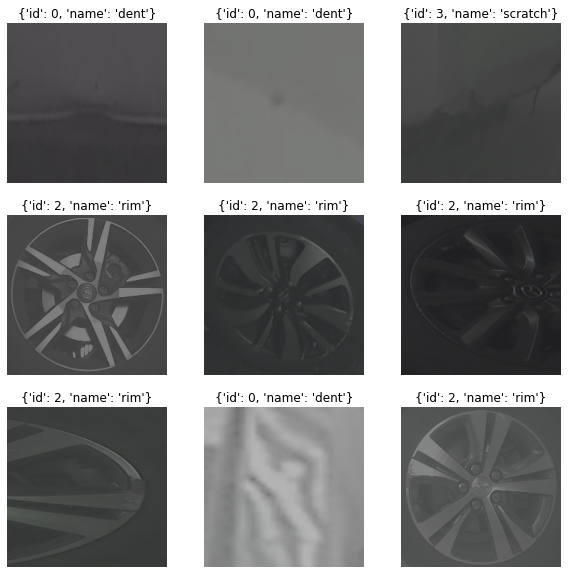

In [8]:
#Augmented plot
plt.figure(figsize=(10, 10))
for image, label in aug_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(categories[label[i]])
        plt.axis("off")

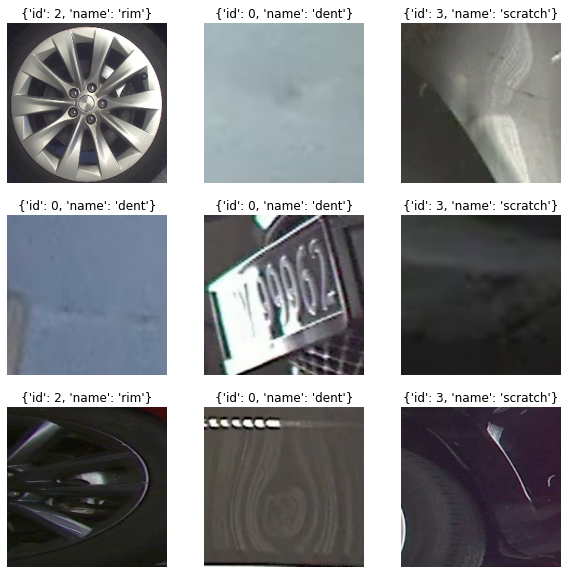

In [9]:
#Plot of train_ds
plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(categories[label[i]])
        plt.axis("off")